In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: subirsarkar252
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 2.09GB/s]

In [3]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from IPython.display import Image
import imutils

In [4]:
os.mkdir("/content/Crop-Brain-MRI/")
os.mkdir("/content/Crop-Brain-MRI/glioma")
os.mkdir("/content/Crop-Brain-MRI/meningioma")
os.mkdir("/content/Crop-Brain-MRI/notumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary")

In [5]:
os.mkdir("/content/Test-Data")
os.mkdir("/content/Test-Data/glioma")
os.mkdir("/content/Test-Data/meningioma")
os.mkdir("/content/Test-Data/notumor")
os.mkdir("/content/Test-Data/pituitary")

DATA VISUALIZATION


In [6]:
train_dir ="/content/brain-tumor-mri-dataset/Training/"
test_dir = "/content/brain-tumor-mri-dataset/Testing/"

In [7]:
classes = os.listdir("/content/brain-tumor-mri-dataset/Training/")

In [8]:
classes

['notumor', 'glioma', 'pituitary', 'meningioma']

In [9]:
filepath_dict = {}

for c in classes :
  filepath_dict[c] = list(map(lambda x : train_dir + c + '/' + x, os.listdir(train_dir + c)))


In [10]:
filepath_dict

{'notumor': ['/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0822.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0814.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0710.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_1182.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_1355.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0166.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_1434.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0020.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_1298.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_1507.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0604.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_1097.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0518.jpg',
  '/content/brain-tumor-mri-dataset/Training/notumor/Tr-no_0320.jpg',
  '/conte

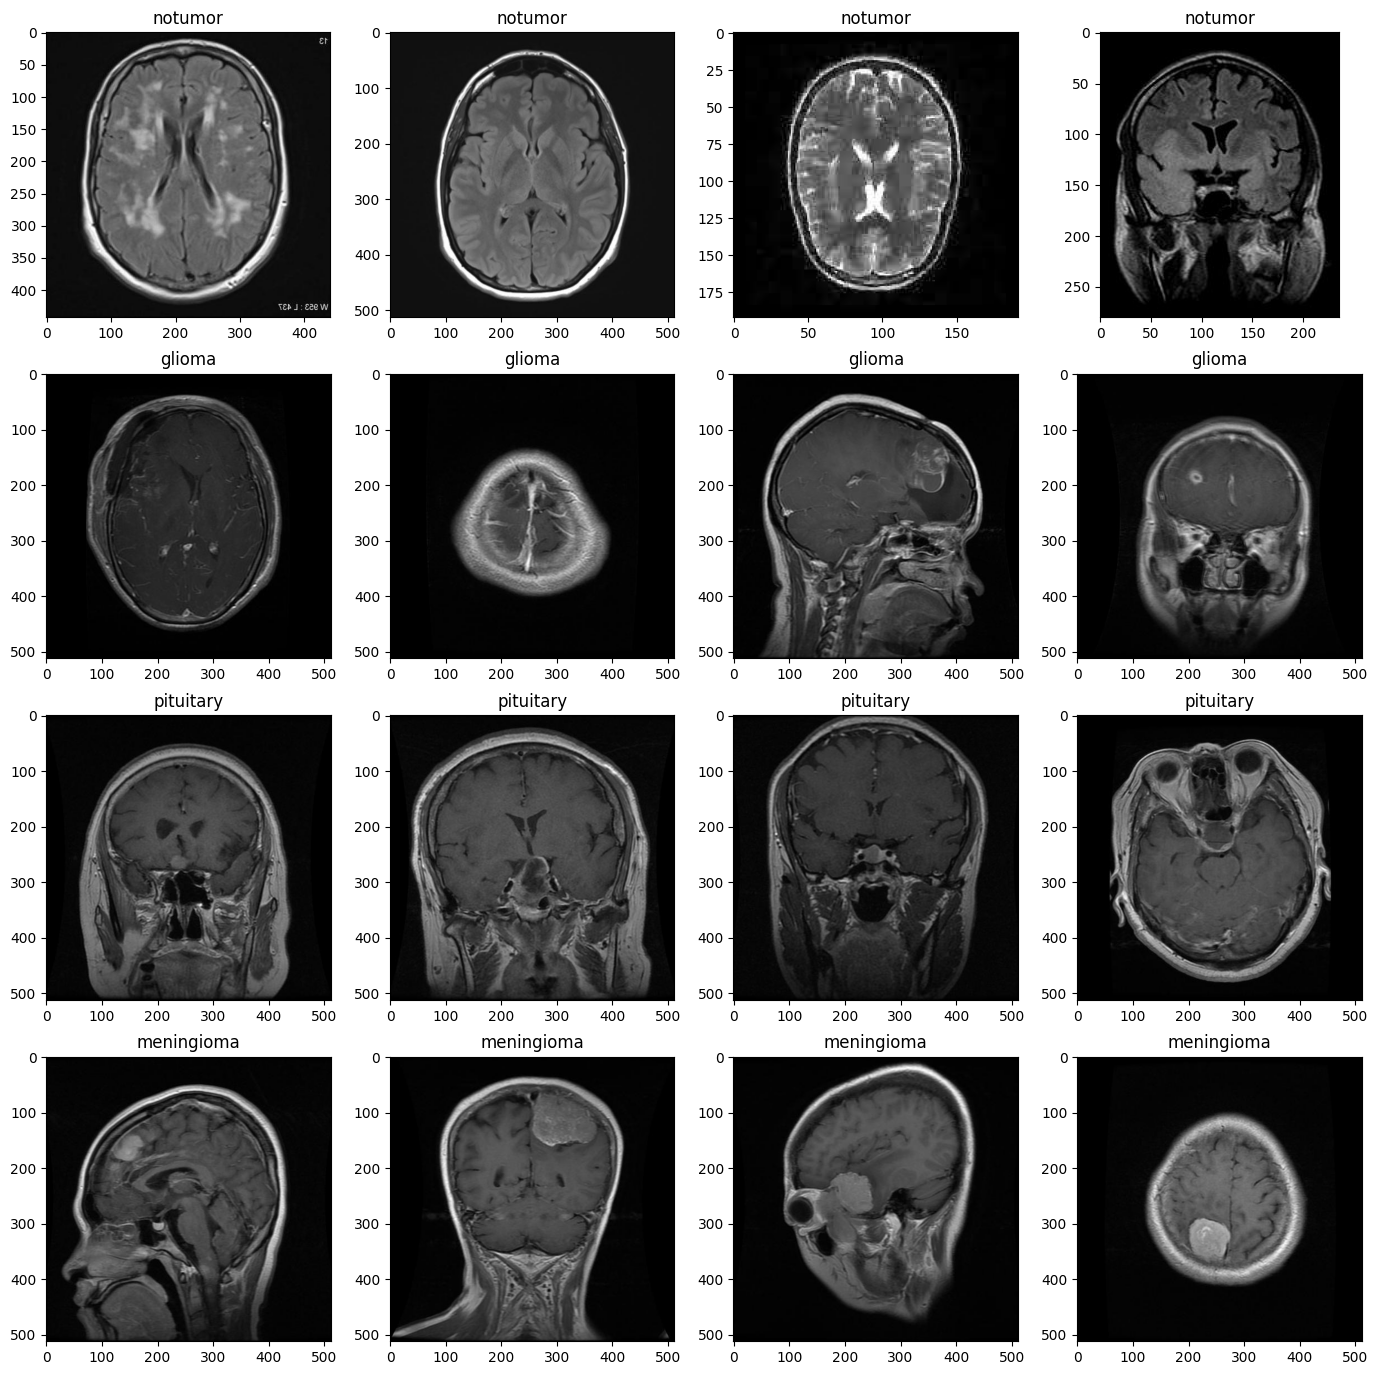

In [11]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure (figsize = (17, 17))

index = 0

for c in classes :
  random.shuffle(filepath_dict[c])
  path_list = filepath_dict[c][:5]

  for i in range(1, 5):
    index +=1
    plt.subplot(4,4,index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)


In [12]:
No_images_per_class = []
Class_name = []
for i in os.listdir("/content/brain-tumor-mri-dataset/Training"):
  train_class= os.listdir(os.path.join("/content/brain-tumor-mri-dataset/Training", i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print(f"Number of images {i} : {len(train_class)}")





Number of images notumor : 1595
Number of images glioma : 1321
Number of images pituitary : 1457
Number of images meningioma : 1339


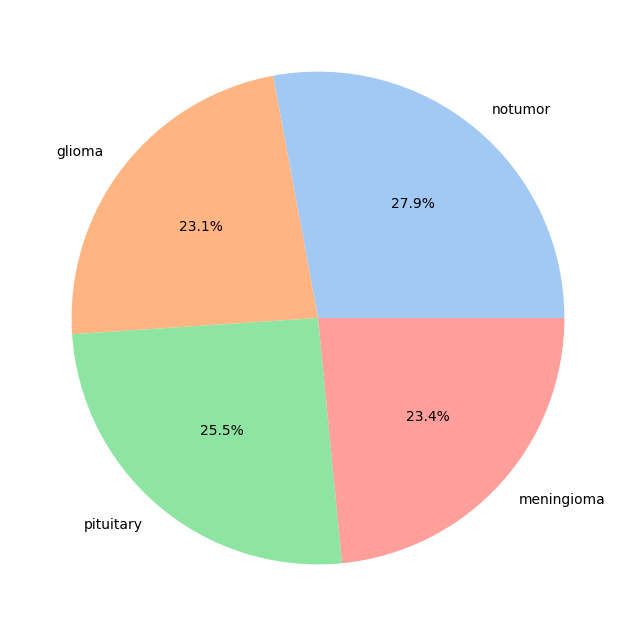

In [13]:
plt.figure(figsize = (8,8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class,labels = Class_name , autopct = "%1.1f%%", colors = colors)
plt.show()

In [14]:
def crop_image(image, plot=False):

  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
  img_thresh = cv2.threshold(img_blur, 45, 255, cv2.THRESH_BINARY)[1]
  img_thresh = cv2.erode(img_thresh, None, iterations = 2)
  img_thresh = cv2.dilate(img_thresh, None, iterations = 2)

  contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  contours = imutils.grab_contours(contours)

  c = max(contours, key = cv2.contourArea)

  extLeft = tuple(c[c[:, :, 0].argmin()])[0]
  extRight = tuple(c[c[:, :, 0].argmax()])[0]
  extTop = tuple(c[c[:, :, 1].argmin()])[0]
  extBottom = tuple(c[c[:, :, 1].argmax()])[0]

  new_img = image[extTop[1]: extBottom[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(new_img)
    plt.title("Cropped Image")
    plt.show()
  return new_img




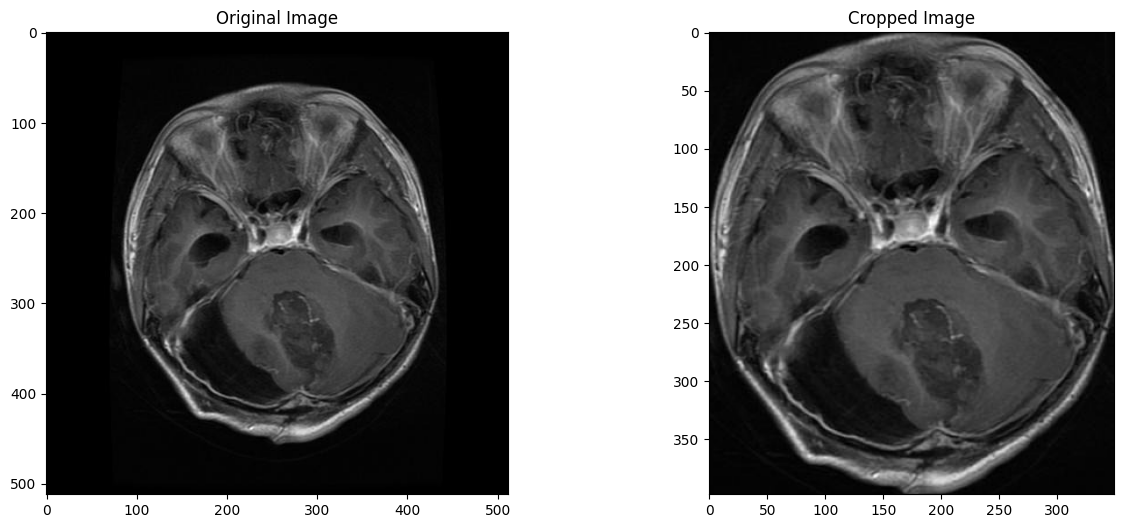

In [15]:
example_img = cv2.imread("/content/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg")
cropped_imgs = crop_image(example_img, plot=True)

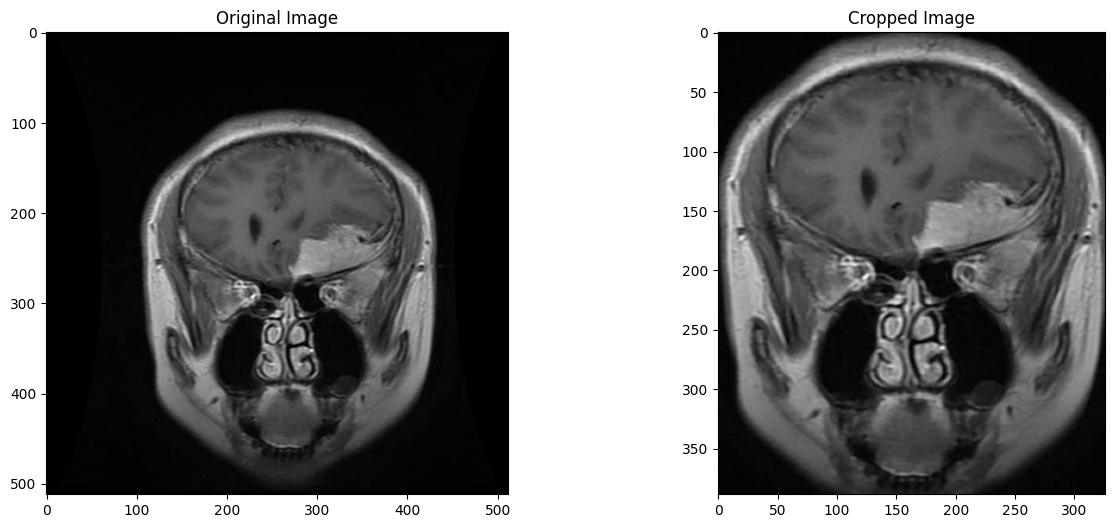

In [16]:
example_img = cv2.imread("/content/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0000.jpg")
cropped_imgs = crop_image(example_img, plot=True)

Saving the cropped Images

In [17]:
glioma = train_dir + 'glioma'
meningioma = train_dir + 'meningioma'
pituitary = train_dir + 'pituitary'
no_tumor = train_dir + 'notumor'
j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/glioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 1321/1321 [00:02<00:00, 512.05it/s]


In [18]:
j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/meningioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/pituitary/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/notumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1


100%|██████████| 1595/1595 [00:02<00:00, 603.27it/s]


In [19]:
len(os.listdir(glioma))

1321

In [20]:
test_glioma = test_dir + 'glioma'
test_meningioma = test_dir + 'meningioma'
test_pituitary = test_dir + 'pituitary'
test_no_tumor = test_dir + 'notumor'
j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/glioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 300/300 [00:00<00:00, 514.36it/s]


In [21]:
j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/meningioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/pituitary/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/notumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 405/405 [00:00<00:00, 770.06it/s]


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [23]:
datagen = ImageDataGenerator(rotation_range = 10,
                             height_shift_range = 0.2,
                             horizontal_flip = True,
                             validation_split = 0.2)

train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                            target_size = (240, 240),
                            batch_size = 32,
                            class_mode = 'categorical', subset = 'training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                            target_size = (240, 240),
                            batch_size = 32,
                            class_mode = 'categorical', subset = 'validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',
                            target_size = (240, 240),
                            class_mode = 'categorical', shuffle = False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [24]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [25]:
test_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

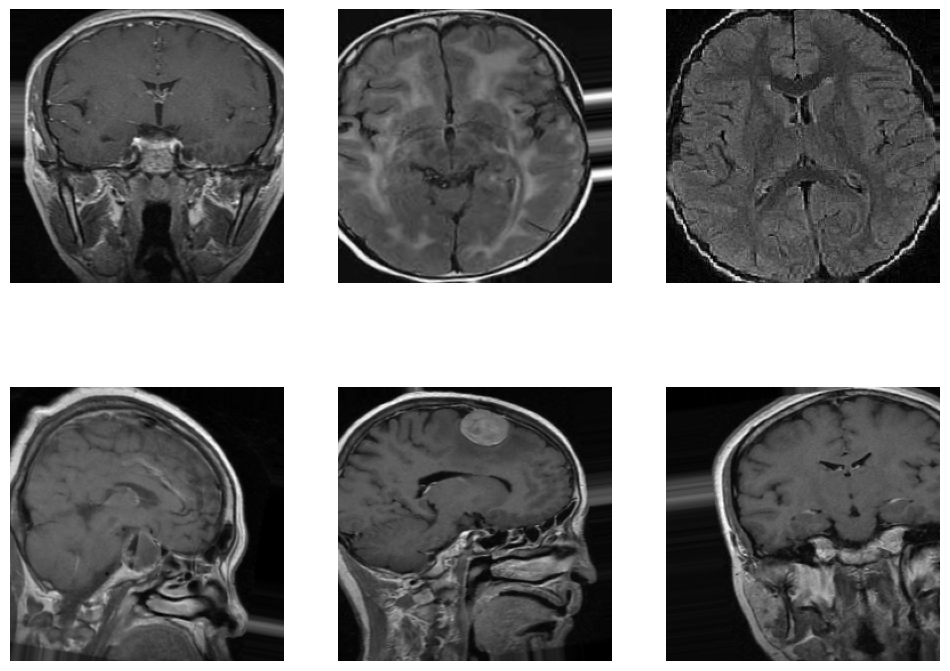

In [26]:

sample_x, sample_y = next(train_data)

plt.figure(figsize = (12, 9))

for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)

plt.show()


In [27]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [28]:
effenet  = EfficientNetB1(weights = 'imagenet', include_top = False, input_shape = (240, 240, 3))

model = effenet.output
model = GlobalMaxPooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=effenet.input, outputs = model)
model.summary()


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [29]:

model.compile(optimizer=Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
checkpoint = ModelCheckpoint('model.keras', monitor = 'val_accuracy',
                save_best_only = True,
                mode = 'auto',
                verbose = 1)
earlystop = EarlyStopping(monitor = 'val_accuracy',
              patience = 5,
              mode = 'auto', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                  factor = 0.3,
                  patience = 2,
                  min_delta = 0.001,
                  mode = 'auto', verbose = 1)

In [30]:
%%time
history = model.fit(train_data, epochs = 30, validation_data = valid_data,
                    verbose = 1, callbacks = [checkpoint, earlystop, reduce_lr])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5023 - loss: 3.8875
Epoch 1: val_accuracy improved from -inf to 0.77914, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 1351s 9s/step - accuracy: 0.5034 - loss: 3.8769 - val_accuracy: 0.7791 - val_loss: 0.8564 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8462 - loss: 0.7953
Epoch 2: val_accuracy improved from 0.77914 to 0.83348, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 1319s 9s/step - accuracy: 0.8462 - loss: 0.7948 - val_accuracy: 0.8335 - val_loss: 0.7257 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8973 - loss: 0.5233
Epoch 3: val_accuracy improved from 0.83348 to 0.87993, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 1313s 9s/step - accuracy: 0.8973 - loss: 0.5228 - val_accuracy: 0.8799 - val_loss: 0.4278 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - ac

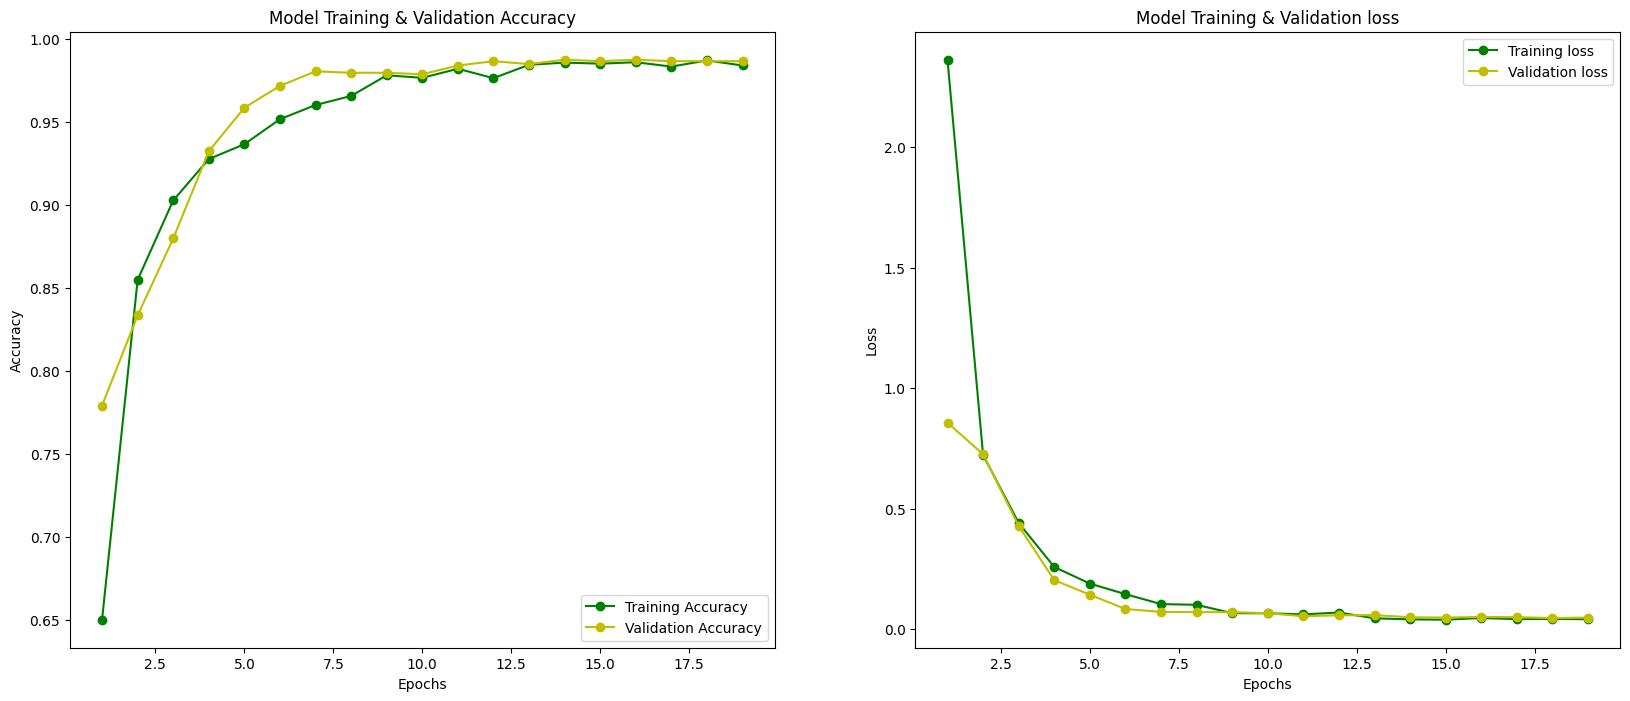

In [31]:
fig, ax = plt.subplots(1 , 2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']


epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'y-o', label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training loss')
ax[1].plot(epochs, val_loss, 'y-o', label = 'Validation loss')
ax[1].set_title('Model Training & Validation loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [32]:
model.evaluate(train_data)

143/143 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9984 - loss: 0.0066


[0.007177660241723061, 0.9978122711181641]

In [33]:
model.evaluate(test_data)

41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9805 - loss: 0.0456


[0.034217409789562225, 0.9885583519935608]

In [34]:
y_test = test_data.classes
y_test_hat = np.argmax(model.predict(test_data), axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step


In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report

In [36]:
cm = confusion_matrix(y_test, y_test_hat)
cm

array([[289,   9,   1,   1],
       [  1, 304,   0,   1],
       [  0,   0, 405,   0],
       [  0,   1,   0, 299]])

In [37]:
test_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

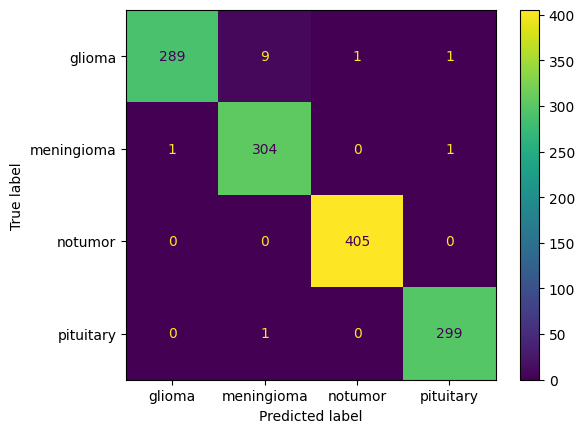

In [38]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])
cm_display.plot()
plt.show()


In [39]:
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       300
           1       0.97      0.99      0.98       306
           2       1.00      1.00      1.00       405
           3       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [40]:
import PIL

CLASS_DICT = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

images = []
prediction = []
original = []

for i in os.listdir('/content/Test-Data'):
  for item in os.listdir(os.path.join('/content/Test-Data', i)):
    img = PIL.Image.open(os.path.join('/content/Test-Data', i, item))
    images.append(img)
    img = np.expand_dims(img, axis = 0)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(CLASS_DICT[predict])
    original.append(i)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/

In [41]:
score = accuracy_score(original, prediction)
score


0.9877955758962624

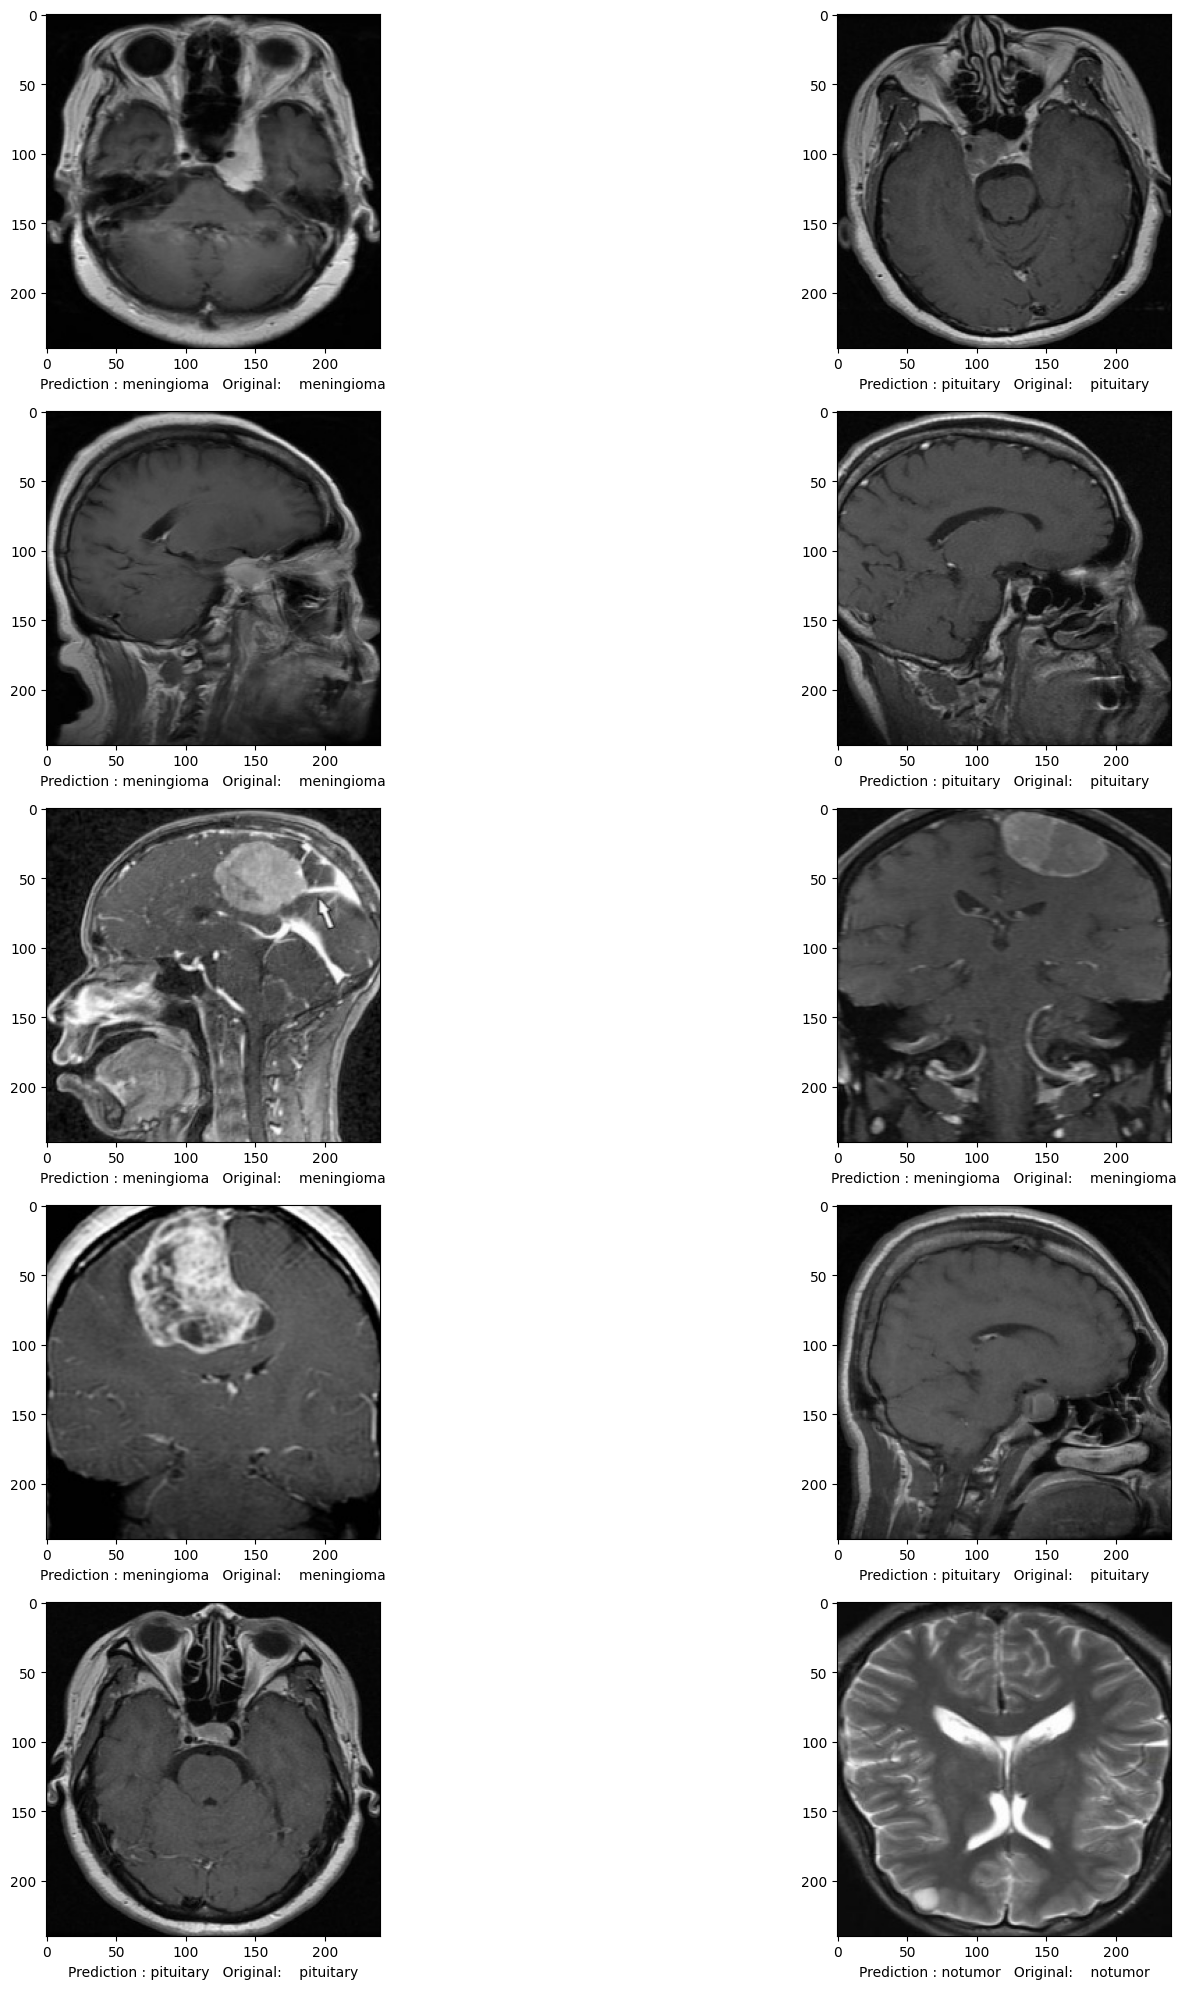

In [42]:
fig = plt.figure(figsize = (20, 20))

for i in range(10):
  j = random.randint(0, len(images))
  fig.add_subplot(5, 2, i+1)
  plt.xlabel("Prediction : " + prediction[j] + "   Original:    " + original[j])
  plt.imshow(images[j])
fig.tight_layout()
plt.show()


In [43]:
import tensorflow as tf
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [44]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/

    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array

    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 240, 240, 3))
  warnings.warn(msg)


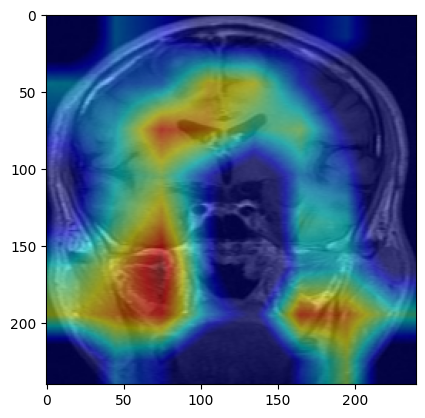

In [45]:
test_img = cv2.imread("/content/Test-Data/glioma/1.jpg")
VizGradCAM(model, img_to_array(test_img), plot_results=True)